In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn import linear_model
from math import *
from util import *

plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
# parseo con fechas
df = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv', parse_dates=[0])
# rename de columnas
df.columns = ['dt', 'avg', 'error', 'country']
# toordinal() para tener una fecha numerica monotona
df['ordinal'] = df['dt'].apply(lambda d: d.toordinal())
# arreglo nombres
df['country'] = df['country'].apply(lambda d: d.replace('_', ' '))
# filtro los NaN
df = df[df.avg.notnull()]

In [3]:
d1960 = datetime(1960, 1, 1)
d1990 = datetime(1990, 1, 1)
data1960_1990 = df[(d1960 < df['dt']) & (df['dt']< d1990)].groupby('country', as_index=False)['avg'].mean()
data1960_1990.head()

,country,avg
0,Afghanistan,14.230730
1,Africa,24.254075
2,Albania,12.792914
3,Algeria,23.256357
4,American Samoa,26.772630


# Media histórica

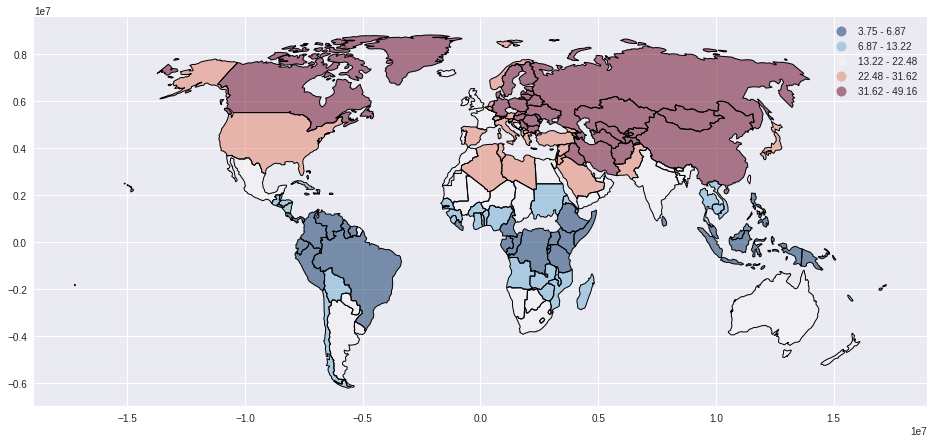

In [32]:
means = df.groupby('country', as_index=False)["avg"].aggregate(["min", "max"])
means["amplitude"] = means["max"] - means["min"]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[33, "name"] = "Congo (Democratic Republic Of The)"
world = world.set_index('name')
join = world.join(means, how='inner').to_crs('+proj=natearth')
join.plot(column='amplitude', cmap='RdBu_r', scheme='quantiles', legend=True)

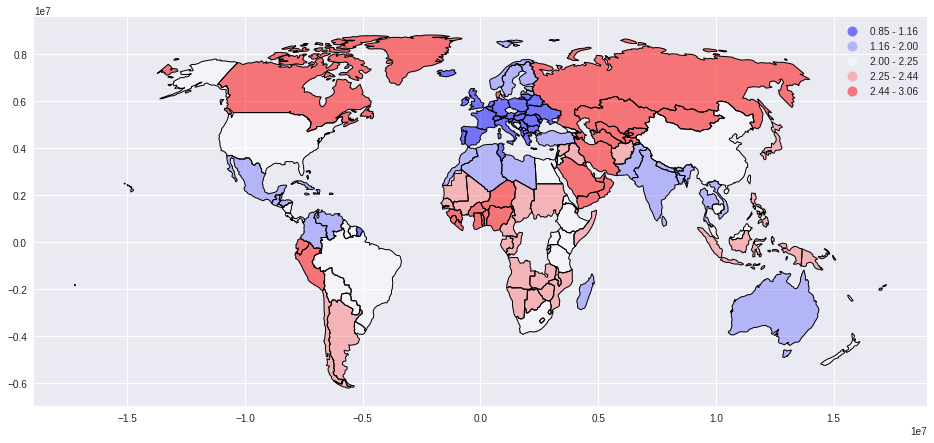

In [5]:
countries = join.index.unique()
p = sns.color_palette("hls", len(countries))
fns = poly(1)

def get_pendiente(c):
    sub_df = df[df['country'] == c]
    A = np.array([fns(x) for x in sub_df['ordinal']], dtype=np.float64)
    ws = np.linalg.lstsq(A, sub_df['avg'])[0]
    return ws[0]*10**5

pendientes = pd.DataFrame({'country': countries, 'pendiente': list(map(get_pendiente, countries))})
pendientes = pendientes.set_index('country')
world.join(pendientes, how='inner')\
    .to_crs('+proj=natearth')\
    .plot(column='pendiente', cmap='bwr', scheme='quantiles', legend=True)